# Coursera project: [Build a Generative Adversarial Network](https://www.coursera.org/learn/deep-learning-with-pytorch-generative-adversarial-network/ungradedLti/BDxG6/deep-learning-with-pytorch-generative-adversarial-network)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# optimizer
lr = 0.002
beta_1 = 0.5
beta_2 = 0.99

In [3]:
#training
epochs = 20
device = 'cuda'
batch_size = 128
noise_dim = 64

In [4]:
#load MNIST
from torchvision import datasets, transforms as T

In [5]:
train_augs = T.Compose([T.RandomRotation((-20, 20)), T.ToTensor()])


In [6]:
trainset = datasets.MNIST('../MNIST/', download=True, transform=train_augs)

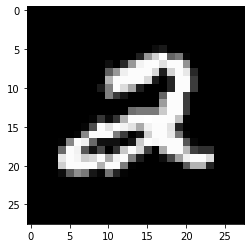

In [7]:
image, label = trainset[5]
plt.imshow(image.squeeze(), cmap='gray')

In [8]:
#load dataset into batches
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [9]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)


In [10]:
print("Total number of batches in trainloader : ", len(trainloader))

Total number of batches in trainloader :  469


In [11]:
dataitr = iter(trainloader)
images, _ = dataitr.next()
print(images.shape)

torch.Size([128, 1, 28, 28])


In [12]:
#show tensor images
def show_tensor_images(tensor_img, num_images=16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

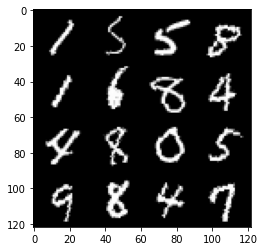

In [13]:
show_tensor_images(images, 16)

In [14]:
# create discriminatory network
from torch import nn
from torchsummary import summary

In [15]:
def get_disciminator_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels), nn.LeakyReLU(0.2))


In [16]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.block_1 = get_disciminator_block(1, 16, (3, 3), 2)
        self.block_2 = get_disciminator_block(16, 32, (5, 5), 2)
        self.block_3 = get_disciminator_block(32, 64, (5, 5), 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=64, out_features=1)

    def forward(self, images):
        x1 = self.block_1(images)
        x1 = self.block_2(x1)
        x1 = self.block_3(x1)

        x1 = self.flatten(x1)
        output = self.linear(x1)

        return output


In [17]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [18]:
# define generator network
def get_generator_block(in_channels,
                        out_channels,
                        kernel_size,
                        stride,
                        final_block=False):

    if final_block == True:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh())
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels), nn.ReLU())


In [19]:
class Generator(nn.Module):

    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.block_1 = get_generator_block(noise_dim, 256, (3, 3), 2)
        self.block_2 = get_generator_block(256, 128, (4, 4), 1)
        self.block_3 = get_generator_block(128, 64, (3, 3), 2)

        self.block_4 = get_generator_block(64, 1, (4, 4), 2, final_block=True)

    def forward(self, r_noise_vec):
        x = r_noise_vec.view(-1, self.noise_dim, 1, 1)
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)

        output = self.block_4(x)
        return output

In [20]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size=(1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [21]:
# Replace Random initialized weights to Normal weights


def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [22]:
D = D.apply(weights_init)
G = G.apply(weights_init)

C:\Users\Saket Saurabh\AppData\Local\Temp\ipykernel_36240\3592469152.py:6: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(m.weight, 0.0, 0.02)


In [23]:
# loss functions
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss


def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss


In [24]:
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))


100%|██████████| 469/469 [00:16<00:00, 28.08it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 1 , D_loss : 0.0, G_loss : 0.970281096409633


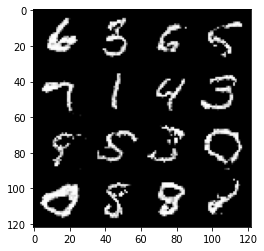

100%|██████████| 469/469 [00:16<00:00, 28.22it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 2 , D_loss : 0.0, G_loss : 0.9818788238171575


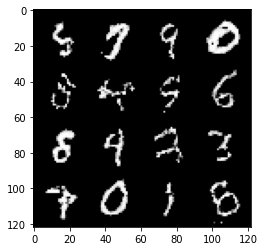

100%|██████████| 469/469 [00:16<00:00, 28.43it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 3 , D_loss : 0.0, G_loss : 1.0051493248197316


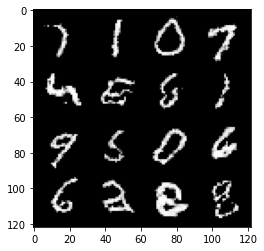

100%|██████████| 469/469 [00:16<00:00, 27.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 4 , D_loss : 0.0, G_loss : 1.029536613269147


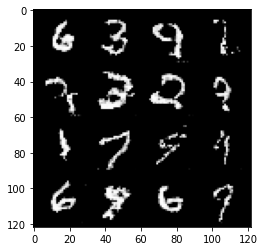

100%|██████████| 469/469 [00:16<00:00, 27.89it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 5 , D_loss : 0.0, G_loss : 1.0619620670641918


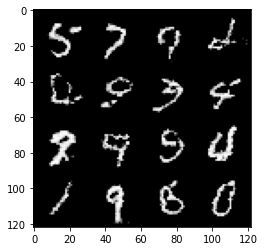

100%|██████████| 469/469 [00:17<00:00, 27.43it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 6 , D_loss : 0.0, G_loss : 1.0876771763189514


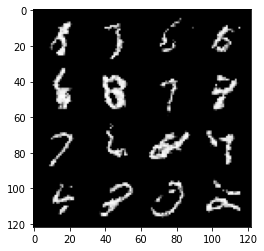

100%|██████████| 469/469 [00:16<00:00, 28.08it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 7 , D_loss : 0.0, G_loss : 1.096198984936102


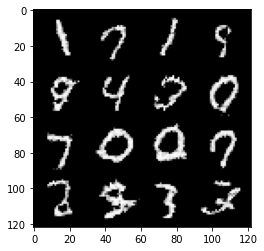

100%|██████████| 469/469 [00:15<00:00, 29.34it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 8 , D_loss : 0.0, G_loss : 1.0886830609998723


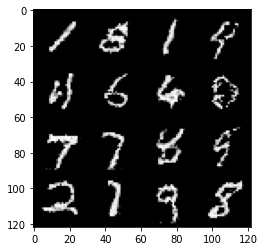

100%|██████████| 469/469 [00:15<00:00, 29.33it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 9 , D_loss : 0.0, G_loss : 1.084210274570278


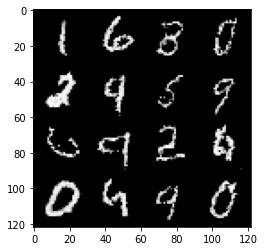

100%|██████████| 469/469 [00:16<00:00, 27.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 10 , D_loss : 0.0, G_loss : 1.0913719594605695


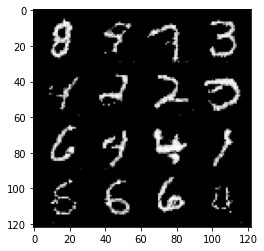

100%|██████████| 469/469 [00:17<00:00, 26.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 11 , D_loss : 0.0, G_loss : 1.094956674809649


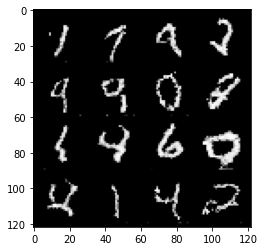

100%|██████████| 469/469 [00:17<00:00, 27.44it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 12 , D_loss : 0.0, G_loss : 1.0978065844792038


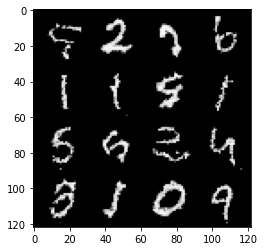

100%|██████████| 469/469 [00:17<00:00, 27.59it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 13 , D_loss : 0.0, G_loss : 1.1109179937000722


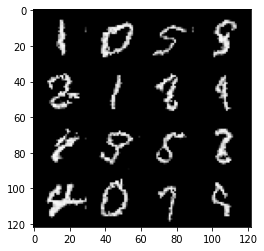

100%|██████████| 469/469 [00:17<00:00, 27.49it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 14 , D_loss : 0.0, G_loss : 1.1226020560844112


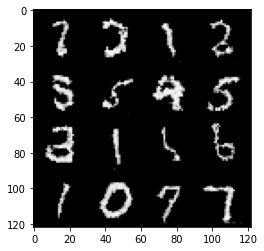

100%|██████████| 469/469 [00:17<00:00, 27.57it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 15 , D_loss : 0.0, G_loss : 1.1317217881237265


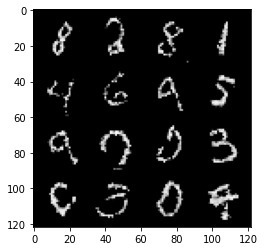

100%|██████████| 469/469 [00:17<00:00, 26.65it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 16 , D_loss : 0.0, G_loss : 1.137165077078317


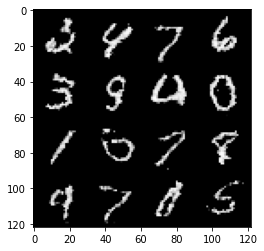

100%|██████████| 469/469 [00:16<00:00, 28.02it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 17 , D_loss : 0.0, G_loss : 1.13323075621367


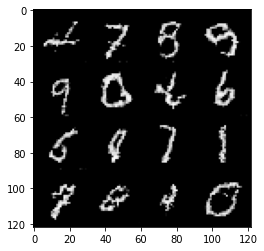

100%|██████████| 469/469 [00:17<00:00, 27.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 18 , D_loss : 0.0, G_loss : 1.1301138805173863


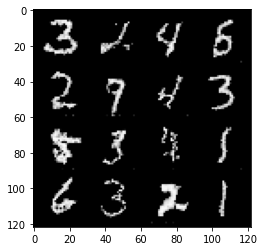

100%|██████████| 469/469 [00:17<00:00, 27.11it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 19 , D_loss : 0.0, G_loss : 1.1337645506299634


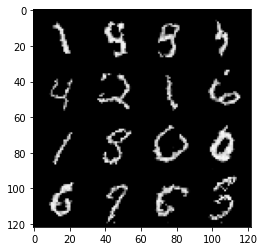

 13%|█▎        | 63/469 [00:02<00:14, 27.32it/s]

In [26]:
# training
from tqdm import tqdm
for i in range(epochs):

    total_d_loss = 0.0
    total_g_loss = 0.0

    for real_img, _ in tqdm(trainloader):
        real_img = real_img.to(device)
        noise = torch.randn(batch_size, noise_dim, device=device)

        D_opt.zero_grad()
        
        fake_img = G(noise)
        D_pred = D(fake_img)
        D_fake_loss = fake_loss(D_pred)

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)

        D_loss = (D_fake_loss + D_real_loss) / 2
        total_d_loss += D_loss.item()

        D_loss.backward()
        D_opt.step()

        G_opt.zero_grad()

        noise = torch.randn(batch_size, noise_dim, device=device)

        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)

        total_g_loss += G_loss.item()

        G_loss.backward()
        G_opt.step()

    avg_d_loss = total_d_loss / len(trainloader)
    avg_g_loss = total_g_loss / len(trainloader)

    print("Epoch : {} , D_loss : {}, G_loss : {}".format(i+1, avg_d_loss, avg_g_loss))
    show_tensor_images(fake_img)
